In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo'dan "-" öncesindeki dört rakamı çıkarıyoruz
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)

# mccinfo değeri bulunamayan satırları siliyoruz
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlarda formatlama işlemleri
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunlar için one-hot encoding
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("Ön işleme tamamlandı.")

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Ön işleme tamamlandı.


In [3]:

target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


In [4]:
X

,basarili_satis_adet,basarili_satis_ciro,basarili_iade_adet,basarili_iade_ciro,Müşteri Skoru,bıst100_Kapanış,bıst100_Açılış,bıst100_Yüksek,bıst100_Düşük,Euro_Kapanış,...,mccinfo_8043,mccinfo_8099,mccinfo_8211,mccinfo_8220,mccinfo_8241,mccinfo_8249,mccinfo_8299,mccinfo_8641,mccinfo_8911,mccinfo_8999
0,247520,1.045249e+08,994,560218.63,58.62,1.492,1.484,1.500,1.471,8.6684,...,False,False,False,False,False,False,False,False,False,False
1,10683,2.685102e+06,10,5521.15,64.08,1.408,1.405,1.412,1.400,9.6543,...,False,False,False,False,False,False,False,False,False,False
2,289,3.024150e+04,67,3385.00,61.36,1.375,1.393,1.398,1.374,9.6964,...,False,False,False,False,False,False,False,False,False,False
3,3,1.867700e+04,0,0.00,51.42,1.392,1.381,1.397,1.381,9.9102,...,False,False,False,False,False,False,False,False,False,False
4,856,6.864042e+06,5,9880.55,44.88,1.392,1.381,1.397,1.381,9.9102,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,6,1.164500e+04,0,0.00,56.40,10.872,10.715,10.895,10.683,35.1857,...,False,False,False,False,False,False,False,False,False,False
1703,146,1.790288e+05,5,3357.76,68.90,10.872,10.715,10.895,10.683,35.1857,...,False,False,False,False,False,False,False,False,False,False
1704,10,1.169149e+04,0,0.00,55.28,10.872,10.715,10.895,10.683,35.1857,...,False,False,False,False,False,False,False,False,False,False
1705,1,3.000000e+02,0,0.00,63.60,11.139,11.194,11.252,11.106,36.0076,...,False,False,False,False,False,False,False,False,False,False


In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression


# f_regression ile en iyi 10 özelliği seçiyoruz
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Seçilen Özellikler:", selected_features.tolist())

# XGBoost regressor'ı varsayılan parametrelerle başlatıyoruz.
model = XGBRegressor(random_state=42)

y_pred = cross_val_predict(model, X_selected, y, cv=10)

# Değerlendirme metriklerini hesaplıyoruz.
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

Seçilen Özellikler: ['basarili_satis_adet', 'basarili_satis_ciro', 'Müşteri Skoru', 'mccinfo_5045', 'mccinfo_5599', 'mccinfo_5621', 'mccinfo_5691', 'mccinfo_5734', 'mccinfo_5999', 'mccinfo_8999']
MAE: 0.2781
MAPE: 0.0713
R2: 0.5993


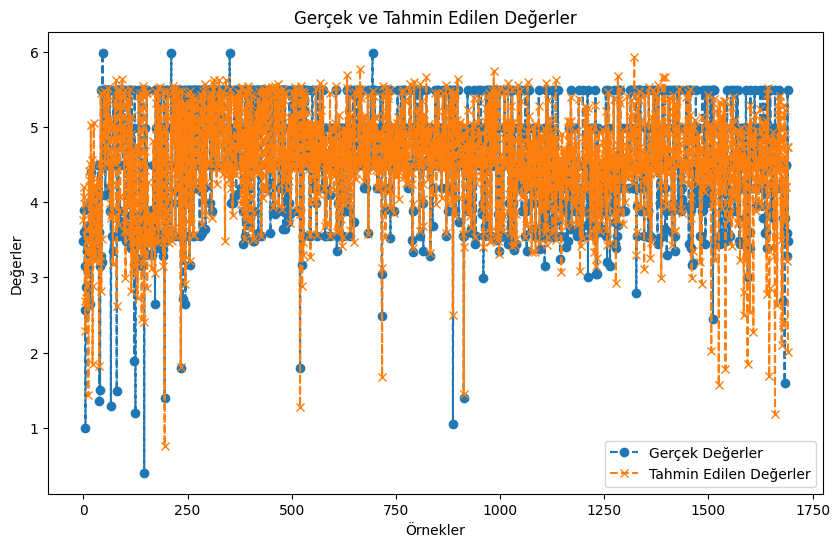

In [6]:
# -------------------- Grafik -------------------- #
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label="Gerçek Değerler", marker="o", linestyle="--")
plt.plot(range(len(y_pred)), y_pred, label="Tahmin Edilen Değerler", marker="x", linestyle="--")
plt.xlabel("Örnekler")
plt.ylabel("Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler")
plt.legend()
plt.show()
